# Data Analysis Using LLM's
### How this tool works: -
1. Sending comments in batches of 2000 to gpt-4's 128k model to get initial topics which the comments are divided into  
2. The summaries for these batches are then consolidated into one JSON file with details that include comment themes, percentage of the theme present in the data, number of positive and negative comments for each topic
3. Save the generated JSON file which we can use for future comparisons
4. Using the data generated we plot 2 graphs; 1. where the percentage of themes is plotted. 2. The number of positive and negative comments for each topic.
5. The images of the plots are saved
6. Finally, we can ask specific question to the data using PandasAI (Eg. How many customers in the survey speak French?)

## Setting up Azure LLM
We use gpt-4-1106-preview with 128k tokens as context

In [41]:
import os
from openai import AzureOpenAI
from dotenv import load_dotenv
import csv

load_dotenv()


#AzureOpenAI setup
client = AzureOpenAI(
    api_key=os.getenv('AZURE_OPENAI_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
    # api_type='azure',
    api_version='2023-05-15',  # this may change in the future
    timeout=20*60,  # 20 minutes
)

#To generate summaries from 1000's of comments
def generate_summary(prompt):
    response = client.chat.completions.create(
        temperature=0.0,
        model="gpt-4-1106-preview",
        messages=[
                {"role": "system", "content":"""You are a product manager.
                """},
                {"role": "user", "content": prompt },
            ]
    )

    return response.choices[0].message.content


#To consolidate different Summaries (The prompt "Business Analyst" makes summaries more concise and to the point.)
def consolidate_summaries(prompt):
    response = client.chat.completions.create(
    temperature=0.0,
    model="gpt-4-1106-preview",
    messages=[
            {"role": "system", "content":"""You are a Business Analyst.
            """},
            {"role": "user", "content": prompt },
        ]
    )
    return response.choices[0].message.content



## Reading from the csv
We can change the name of the CSV and the column name that we want to analyse over here.

In [42]:
column_name = "Q2 - Comment - Recommendations"  #We can extract the column we want to analyse by providing the appropriate name.
with open("survey.csv", 'r', newline='') as csvfile: #We can the input file here.
    reader = csv.DictReader(csvfile)
    if column_name not in reader.fieldnames:
        print("Field name not found!")
    column_data = [row[column_name] for row in reader if row[column_name].strip()]

print(f"Number of comments in the column: {len(column_data)}")

#Making batches of 2000 comments
batch_size = 2000 #We can change the number of comments in each batch, depending on the survey type.
total_batches = (len(column_data) + batch_size - 1)//batch_size
print(f"Number of batches: {total_batches}")


Number of comments in the column: 7044
Number of batches: 4


## Analyzing comments in batches to establish Themes

In [43]:
appended_responses = []

for batch_number in range(total_batches):
    start_index = batch_number * batch_size
    end_index = (batch_number + 1) * batch_size
    comment_batch = column_data[start_index:end_index]
    prompt = """As a poduct manager, analyze if the comments seperated by a single quotes are positive or negative and give the weight by occurence of each topic % 
    give a summary in the following JSON format.
        {
    "date": "Todays_Date",
    "theme_weights": {
        "Theme 1": [{theme1_percentage}%, number of positive comments, number of negative comments],",
        "Theme 2": [{theme2_percentage}%, number of positive comments, number of negative comments]%",
        "Theme 3": [{theme3_percentage}%, number of positive comments, number of negative comments]%
    }
    "Summary": "Consolidated Summary of all the comments"
    }
    comments:""" + f"```{comment_batch}```"
    summary = generate_summary(prompt)
    print(f"######Summary of batch number {batch_number}: -")
    print(summary)
    appended_responses.append(summary)

######Summary of batch number 0: -
Based on the provided comments, it is clear that there are mixed sentiments among users regarding the service. To provide a comprehensive analysis, I will categorize the comments into three main themes: Service Quality, Customer Support, and Product Features. I will then determine the percentage of positive and negative comments for each theme and provide a summary.

**Service Quality:**
- Positive Comments: Users appreciate the call quality, ease of use, and reliability when the service works as expected. They also value the flexibility and mobility the service offers, especially for remote work.
- Negative Comments: Users report issues with call drops, poor call quality, app glitches, and connectivity problems. Some also mention delays in answering calls and static noise.

**Customer Support:**
- Positive Comments: Some users report excellent customer service experiences, with helpful and responsive support staff.
- Negative Comments: There are nume

## Consolidating different responses recieved from the LLM

In [53]:
prompt3 = """
As a business Analyst, 
analyze the following summaries seperated by single quotes and give the consolidated weight by occurence percentage(%) for every theme along with a comprehensive summary,
Generate a JSON file in the following format:

{
  "date": "Todays_Date",
  "theme_weights": {
      "Theme 1": [{theme1_percentage}%, number of positive comments, number of negative comments],",
      "Theme 2": [{theme2_percentage}%, number of positive comments, number of negative comments]%",
      "Theme 3": [{theme3_percentage}%, number of positive comments, number of negative comments]%
  }
  "Summary": "Consolidated Summary of all the comments"
}
""" + f"Seperate Summaries:```{appended_responses}```"

#Comparing the summaries and generating a final summary
final_analysis = consolidate_summaries(prompt3)
print(final_analysis)

To consolidate the summaries and generate a comprehensive analysis, I will first identify the common themes across all summaries. The themes mentioned are:

1. Service Quality (which includes Call Quality and System Usability)
2. Customer Support (which includes Customer Service)
3. Product Features (which includes App Performance and specific features mentioned)

Next, I will calculate the average percentage weight for each theme and the total number of positive and negative comments. The percentages provided in the summaries are estimates, so I will average them for a more accurate representation. For the purpose of this analysis, I will consider "System Usability" as part of "Service Quality" and "Customer Service" as part of "Customer Support".

Here is the consolidated data:

**Service Quality (Service Quality + Call Quality + System Usability):**
- Positive Comments: (60+120+12+15)/4 = 51.75 ≈ 52
- Negative Comments: (90+180+20+10)/4 = 75
- Average Percentage: (40%+40%+25%+45%)/4

## Extracting the JSON file and saving with todays date

In [54]:
import json
from datetime import date

start_index = final_analysis.find('{')
end_index = final_analysis.rfind('}')

if start_index != -1 and end_index != -1:
    json_part = final_analysis[start_index:end_index+1]
    print(json_part)
    try:
        # Load the JSON part using a JSON parser
        json_data = json.loads(json_part)
        json_data["date"] = str(date.today()) #GPT can't get dates right :(
        print("Extracted JSON:", json_data)
        file_path = f"analysis_{str(date.today())}.json"
        with open(file_path, 'w') as json_file:
            json.dump(json_data, json_file, indent=4)
    except json.JSONDecodeError:
        print("Invalid JSON structure.")

        

{
    "date": "2023-04-14",
    "theme_weights": {
        "Service Quality": ["37.5%", 52, 75],
        "Customer Support": ["27.5%", 38, 87],
        "Product Features": ["25%", 68, 87],
        "Billing Issues": ["10%", 1, 9],
        "Reliability": ["15%", 7, 8]
    },
    "Summary": "The analysis of user comments reveals mixed sentiments across several themes. Service Quality is a major concern, with a significant number of users experiencing technical issues, although there is also appreciation for the system's usability when it functions well. Customer Support is another critical area, with many users dissatisfied with the service received, despite some positive interactions. Product Features are generally well-received, but users are looking for enhancements and more intuitive design. Billing issues and reliability are also noted concerns, indicating areas where the service could improve to enhance customer satisfaction."
}
Extracted JSON: {'date': '2024-01-29', 'theme_weights'

## Plotting the data for percentage of occurance of themes 
Here we can see the most common topics that are mentioned in the survey along with an overall summary. 

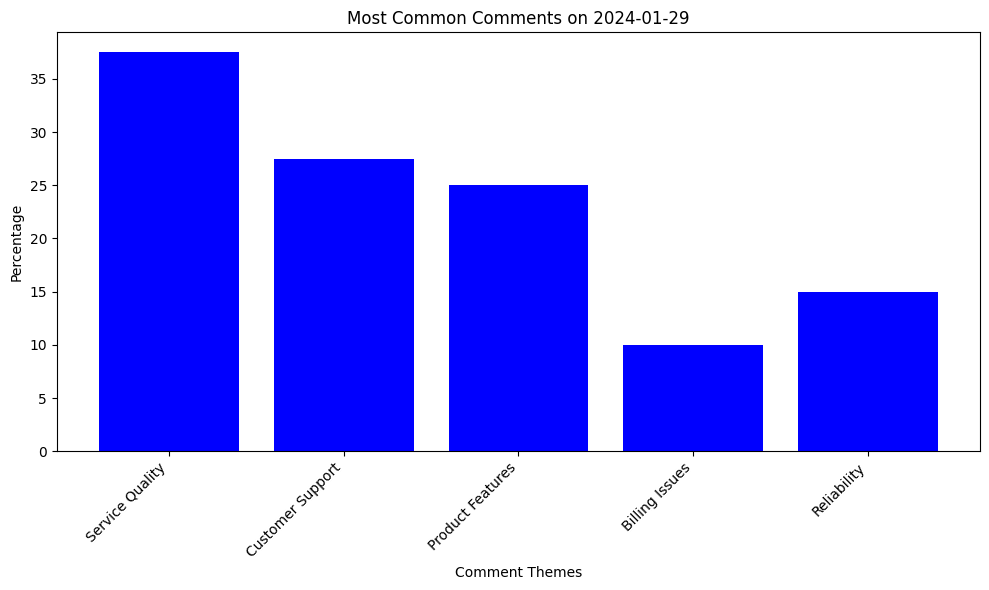

Executive Summary: The analysis of user comments reveals mixed sentiments across several themes. Service Quality is a major concern, with a significant number of users experiencing technical issues, although there is also appreciation for the system's usability when it functions well. Customer Support is another critical area, with many users dissatisfied with the service received, despite some positive interactions. Product Features are generally well-received, but users are looking for enhancements and more intuitive design. Billing issues and reliability are also noted concerns, indicating areas where the service could improve to enhance customer satisfaction.


In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) #Setting the figure size in inches

# Extracting data for plotting
date = json_data["date"]
theme_weights = json_data["theme_weights"]

themes = list(theme_weights.keys())
percentages = [float(weight[0][:-1]) for weight in theme_weights.values()]

# Plotting the histogram
plt.bar(themes, percentages, color='blue')
plt.xticks(rotation=45, ha='right') #Rotating and aligning the x-axis labels
plt.xlabel('Comment Themes')
plt.ylabel('Percentage')
plt.title(f'Most Common Comments on {date}')
plt.tight_layout()  # Adjusts the layout
plt.savefig('bar_plot.png', dpi=300)  # saves the plot as 'bar_plot.png' with the specified dpi
plt.show()

print(f"Executive Summary: {json_data['Summary']}")



## Plotting the Positive and Negative comments for each Topic

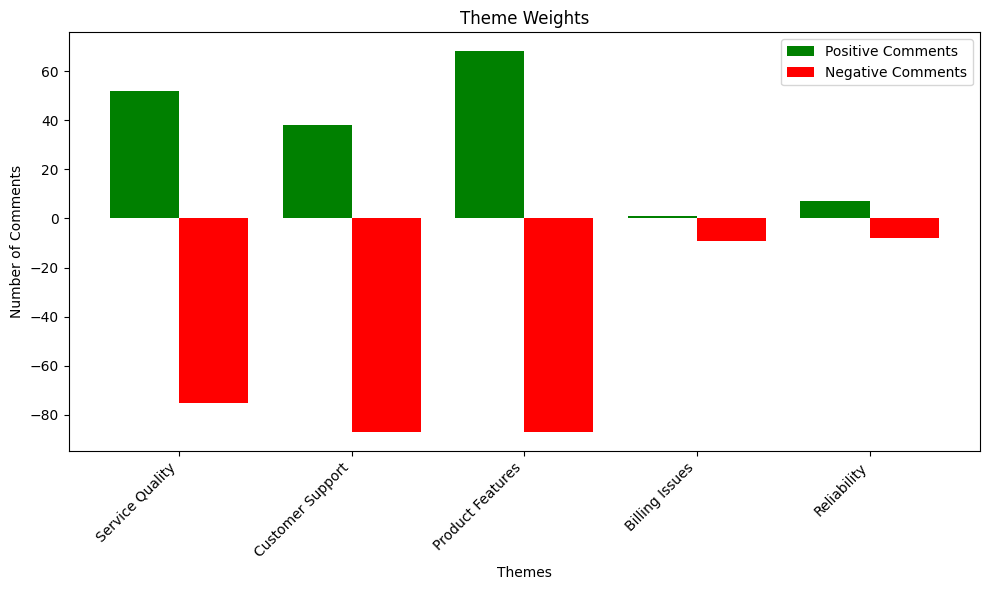

In [60]:
import numpy as np

# Extracting data for plotting
themes = list(theme_weights.keys())
positive_comments = [weight[1] for weight in theme_weights.values()]
negative_comments = [-weight[2] for weight in theme_weights.values()]

pos = np.arange(len(themes))
width = 0.4

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(pos - width/2, positive_comments, width, color='green', label='Positive Comments')
plt.bar(pos + width/2, negative_comments, width, color='red', label='Negative Comments')
plt.xticks(pos, themes, rotation=45, ha='right')
plt.xlabel('Themes')
plt.ylabel('Number of Comments')
plt.title('Theme Weights')
plt.legend()

plt.tight_layout()  # Adjusts the layout
plt.savefig('comment_distribution.png', dpi=300)  # saves the plot as 'theme_weights.png' with a resolution of 300 dpi
plt.show()

## Comparing with previous data stored as JSON.

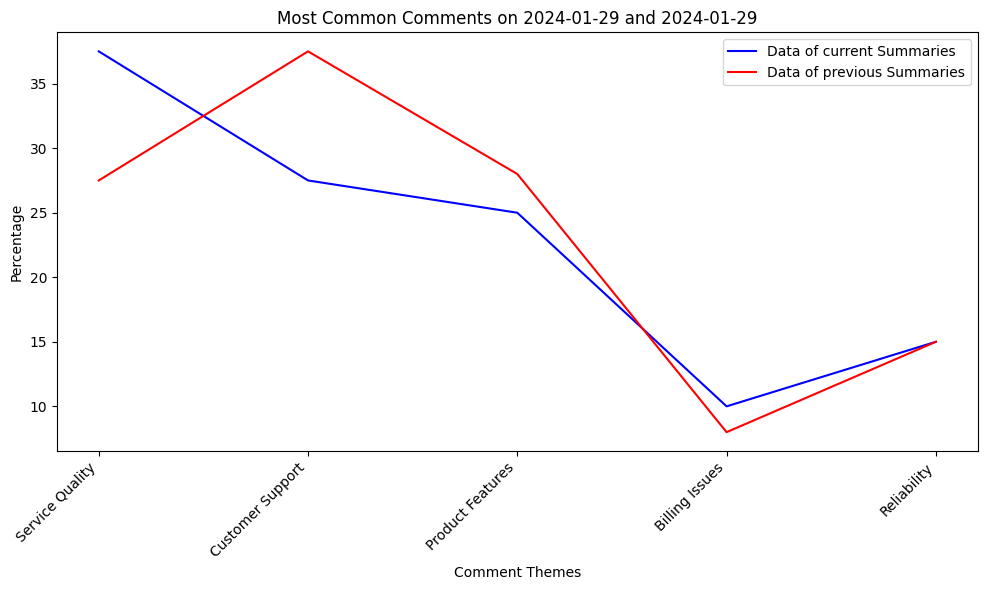

In [59]:
#Comparing json_data with the previous data

#Reading data from JSON file
with open('analysis_2023-04-14.json') as json_file: #We can change the file name here to the file we wish to compare the data with.
    old_data = json.load(json_file)

#Extracting data for plotting
old_date = old_data["date"]
old_theme_weights = old_data["theme_weights"]

old_themes = list(old_theme_weights.keys())
old_percentages = [float(weight[0][:-1]) for weight in old_theme_weights.values()]

#comparison of the data
plt.figure(figsize=(10, 6)) #Setting the figure size in inches
plt.plot(themes, percentages,label='Data of current Summaries', color='blue')
plt.plot(old_themes, old_percentages, label='Data of previous Summaries', color='red') #new percentages
plt.xticks(rotation=45, ha='right') #Rotating and aligning the x-axis labels
plt.xlabel('Comment Themes')
plt.ylabel('Percentage')
plt.title(f'Most Common Comments on {date} and {old_date}')
plt.legend()
plt.tight_layout()  # Adjusts the layout
plt.show()

# Pandas-AI experimentation

In [62]:
import pandas as pd
from pandasai import SmartDataframe
from pandasai.llm import AzureOpenAI

llm = AzureOpenAI(
    api_token=os.getenv('AZURE_OPENAI_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
    api_version="2023-05-15",
    deployment_name="gpt-4-1106-preview"
)

df = SmartDataframe("survey.csv", config={'llm': llm}) #Loading the survey data here

## Can ask specific question to the data
For more granularity we can ask exact question about the data using PandasAI. Some Exmple queries are: -
1. Give me the number of non-english speakers in the surver
2. Give me a pie chart of the distribution of languages customers speak in the survey data with a clear legend
3. How many customers were present in the survey.

In [63]:
response = df.chat("Give me the number of non-english speaking people in the survey.")
print(response)

1317
